# Making Entity Resolution Scale with pyJedAI

## Reading the dataset

In order to perform, pyJedAI only requires the tranformation of the original input data into a pandas DataFrame. Hence, pyJedAI can function with every structured or semi-structured data. In this case, the original dataset is provided as a CSV file.

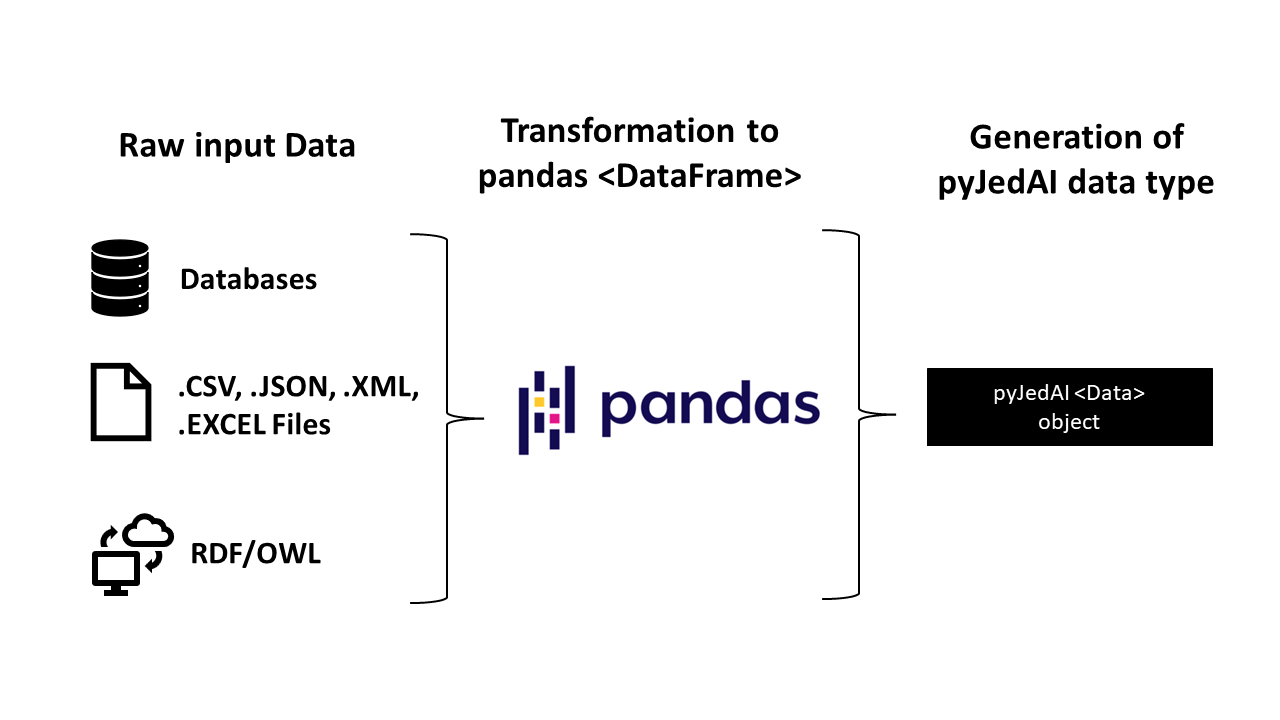

### Load the dataset

Load the dataset as a pandas DataFrame.

In [ ]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
path_data = "datasets/altosight_usb_sticks_small/"
ds = pd.read_csv(path_data + "dataset.csv")
ds

Preprocess the dataset (e.g., all string attributes in lowercase).

In [ ]:
str_attrs = ["name", "brand"]
for attr in str_attrs:
    ds[attr] = ds[attr].apply(lambda x: x.lower() if isinstance(x, str) else x)
ds

### Load the ground truth

Load the ground truth as a pandas DataFrame.

In [ ]:
gold = pd.read_csv(path_data + "matches.csv")
gold

Visualize a pair of matching records.

In [ ]:
ds[(ds["_id"] == "altosight_000") | (ds["_id"] == "altosight_004")]

### Select attributes for blocking

In [ ]:
attrs = ["_id", "name", "brand", "size"]

### Initialize pyJedAI Data module

Data is the connecting module of all steps of the workflow. It stores a hidden mapping of the IDs, and creates them if not existing.

In [ ]:
from pyjedai.datamodel import Data

In [ ]:
data = Data(
    dataset_1=ds,
    id_column_name_1="_id",
    ground_truth=gold,
    attributes_1=attrs
)

## Blocking Workflow

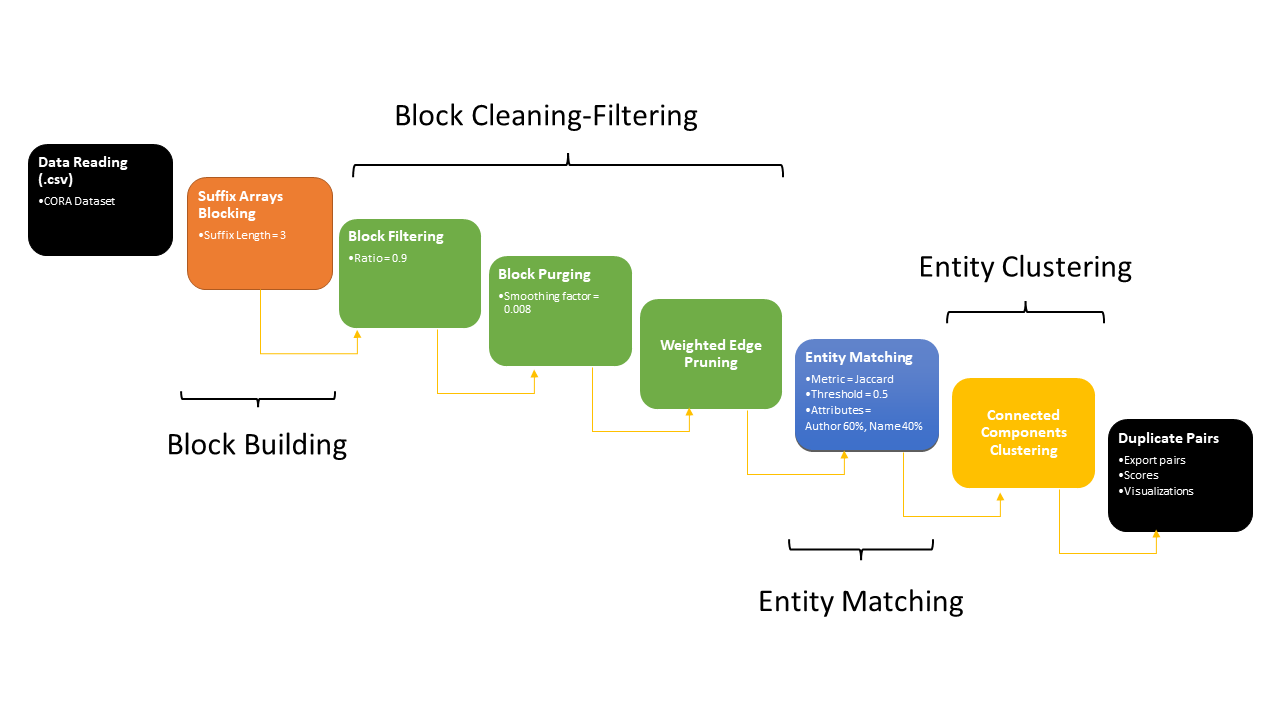

### Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking: creates one block for every token in the attribute values of at least two entities.

- Q-Grams Blocking: creates one block for every q-gram that is extracted from any token in the attribute values of any entity (the q-gram must be shared by at least two entities).
    - qgrams: int = 6

- Extended Q-Grams Blocking: creates one block for every combination of q-grams that represents at least two entities (the q-grams are extracted from any token in the attribute values of any entity).
    - instead of individual Q-garams it combines Q-grams
        - qgrams: int = 6
        - threshold: float = 0.95 (need to "limit" the numebr of Q-grams per combination)

- Suffix Arrays Blocking: creates one block for every suffix that appears in the attribute value tokens of at least two entities.
    - suffix_length: int = 6
    - max_block_size: int = 53

- Extended Suffix Arrays Blocking: creates one block for every substring (not just suffix) that appears in the tokens of at least two entities.
    - suffix_length: int = 6
    - max_block_size: int = 39

https://github.com/AI-team-UoA/pyJedAI/blob/main/src/pyjedai/block_building.py

In [ ]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)

In [ ]:
bb = StandardBlocking()
blocks = bb.build_blocks(data)

In [ ]:
_ = bb.evaluate(blocks)

### Block Purging

Discards the blocks exceeding a certain number of comparisons.

Parameters:
- smoothing_factor: float = 1.025

https://github.com/AI-team-UoA/pyJedAI/blob/main/src/pyjedai/block_cleaning.py

In [ ]:
from pyjedai.block_cleaning import BlockPurging

In [ ]:
bp = BlockPurging(smoothing_factor=1.05)
purging_blocks = bp.process(blocks, data, tqdm_disable=False)

In [ ]:
_ = bp.evaluate(purging_blocks)

### Block Filtering

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

Block filtering retains every entity in a subset of its smallest blocks and consists of multiple steps:
- Blocks are sorted by ascending cardinality.
- Creation of Entity Index: inversed block dictionary.
- Retain every entity in ratio % of its smallest blocks.
- Blocks reconstruction.

Parameters:
- ratio: float = 0.8 (between 0.0 and 1.0)

https://github.com/AI-team-UoA/pyJedAI/blob/main/src/pyjedai/block_cleaning.py

In [ ]:
from pyjedai.block_cleaning import BlockFiltering

In [ ]:
bf = BlockFiltering(ratio=0.95)
filtering_blocks = bf.process(purging_blocks, data)

In [ ]:
_ = bf.evaluate(filtering_blocks)

### Comparison Cleaning

Similar to block cleaning, this step aims to clean a set of blocks from both redundant and superfluous comparisons. Unlike block cleaning, these methods operate on the finer granularity of individual comparisons.

The following methods are currently supported:

- Comparison Propagation: eliminates all redundant comparisons from a set of overlapping blocks.

- Cardinality Edge Pruning (CEP): retains the comparisons that correspond to the top-k weighed edges in the blocking graph.
    - weighting_scheme: str = 'JS'

- Cardinality Node Pruning (CNP): retains for every node the comparisons that correspond to its top-k weighed edges in the blocking graph.
    - weighting_scheme: str = 'CBS'

- Weighed Edge Pruning (WEP): retains all comparisons that have a weight higher than the average edge weight in the blocking graph.
    - weighting_scheme: str = 'CBS'

- Weighed Node Pruning (WNP): retains for every entity the comparisons that correspond to edges in the blocking graph that exceed the average edge weight in the respective node neighborhood.
    - weighting_scheme: str = 'CBS'

- Reciprocal Cardinality Node Pruning (ReCNP): retains the comparisons that correspond to edges in the blocking graph that are among the top-k weighed ones for both adjacent entities/nodes.
    - weighting_scheme: str = 'CN-CBS'

- Reciprocal Weighed Node Pruning (ReWNP): retains the comparisons that correspond to edges in the blocking graph that exceed the average edge weight in both adjacent node neighborhoods.
    - weighting_scheme: str = 'CN-CBS'

- BLAST: retains the comparisons that correspond to edges in the blocking graph that exceed 1/4 of the sum of the maximum edge weights in the two adjacent node neighborhoods.
    - weighting_scheme: str = 'X2'

...plus multiple progressive techniques that operate according to the specified budget (Progressive Cardinality Edge Pruning, Progressive Cardinality Node Pruning, Progressive Sorted Neighborhood, Global Progressive Sorted Neighborhood, Local Progressive Sorted Neighborhood, Progressive Entity Scheduling)

Most of these methods are meta-blocking techniques. All methods are optional, but competitive, in the sense that only one of them can part of an ER workflow. They can be combined with one of the following weighting schemes:
- Aggregate Reciprocal Comparisons Scheme (ARCS)
- Common Blocks Scheme (CBS)
- Enhanced Common Blocks Scheme (ECBS)
- Jaccard Scheme (JS)
- Enhanced Jaccard Scheme (EJS)

https://github.com/AI-team-UoA/pyJedAI/blob/main/src/pyjedai/comparison_cleaning.py

In [ ]:
from pyjedai.comparison_cleaning import (
    ComparisonPropagation,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    WeightedEdgePruning,
    WeightedNodePruning,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    BLAST
)

In [ ]:
mb = WeightedEdgePruning(weighting_scheme='CBS')
comparisons = mb.process(filtering_blocks, data)

In [ ]:
_ = mb.evaluate(comparisons)

### Generate the candidate set

Retrieve the mapping from the pyJedAI IDs to the original IDs.

In [ ]:
id_mapping = {d[1]: d[0] for d in data._ids_mapping_1.items()}
id_mapping[0]

Represent the candidates as a set of pairs of original IDs, then generate the related pandas DataFrame.

In [ ]:
import random

In [ ]:
candidates = {(id_mapping[cand[0]], id_mapping[cand[1]]) if id_mapping[cand[0]] < id_mapping[cand[1]]
              else (id_mapping[cand[1]], id_mapping[cand[0]]) for cand in [(l_id, r_id) for r_id in comparisons.keys() for l_id in comparisons[r_id]]}
print(random.choice(list(candidates)))
len(candidates)

In [ ]:
candidates = pd.DataFrame(candidates, columns=["l_id", "r_id"])
candidates

In [ ]:
candidates.to_csv("candidates.csv", index=False)